<h1 style="background-color:rgb(67, 77, 86);
           font-size:300%;
           font-style: oblique;
           color:white;
           text-align:center;
           margin: auto;
           padding: 20px;">Predicting Bank Churners</h1>

<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Chapter 3: Data Cleaning</h2>

<a id='1.1'>
    <h2 style='font-size:180%;'>
        Mission</h2></a>

<figure>
    <blockquote cite='https://www.kaggle.com/sakshigoyal7/credit-card-customers/tasks?taskId=2729'>
        <p style='font-size:110%;
                  color:hsl(208, 12%, 30%);'><i>Our top priority in this business problem is to identify customers who are getting churned. Even if we predict non-churning customers as churned, it won't harm our business. But predicting churning customers as non-churning will do. So recall needs to be higher. Till now, I have managed to get a recall of 62%.</i></p>
    </blockquote>
    <figcaption>—Sakshi Goyal, <cite>Credit Card Customers, Kaggle</cite></figcaption>

<h2 style='font-size:180%;'>
    Table of Contents
</h2>

* [Initial Preparation](#4)
    * [Libraries](#4.1)
    * [Data Loading](#4.2)
* [Normality Test](#5)
    * [Histograms](#5.1)
    * [Skewness & Kurtosis](#5.2)
    * [QQ Plots](#5.3)
    * [Statistical Tests](#5.4)
        * [D'Agostino's K Square](#5.4.1)
        * [Anderson Test](#5.4.2)
        * [Jarque–Bera Test](#5.4.3)
* [Baseline Models](#6)
    * [Logistic Regression](#6.1)
    * [Gradient Boosting Classifier](#6.2)
* [Outlier Treatment](#7)
    * [Isolation Forest](#7.1)
    * [Fit on All Classes](#7.2)
        * [Logistic Regression](#7.2.1)
        * [Gradient Boosting Classifier](#7.2.2)
    * [Evaluate Results](#7.3)
            

<a id='4'>
    <h2 style='background-color:rgb(141, 153, 165);
               font-size:240%;
               color:white;
               text-align:center;
               margin: auto;
               padding: 10px;'>
        Initial Preparation
    </h2>
</a>

<a id='4.1'>
    <h2 style='font-size:210%;'>
        Libraries
    </h2>
</a>

In [1]:
global_built_ins = dir()
global_built_ins.append('global_built_ins')

In [2]:
# general
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import statsmodels.api as sm

# statistics
from numpy import (mean, std)
from scipy.stats import (
    normaltest, anderson, jarque_bera)

# machine learning prep
from collections import Counter
from sklearn.model_selection import (
    train_test_split, cross_validate, cross_val_predict,
    RepeatedStratifiedKFold)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, fbeta_score, 
    confusion_matrix, make_scorer, SCORERS)
from imblearn.pipeline import Pipeline
# from sklearn.pipeline import Pipeline

# machine learning models
from sklearn.ensemble import (GradientBoostingClassifier, IsolationForest)
from sklearn.linear_model import LogisticRegression

# warning
# import warnings
# warnings.filterwarnings('ignore', category=RuntimeWarning)
# warnings.filterwarnings('ignore', category=FutureWarning)
# warnings.filterwarnings('ignore', category=DeprecationWarning)

# saving
import os

# efficiency
from time import time

# Display Settings

In [3]:
# display settings
%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(suppress=True, precision=3)

In [4]:
%%html
<style>
/* CSS styles for pandas dataframe */
.dataframe th {
    font-size: 16px;
}
.dataframe td {
    font-size: 14px;
}
</style>

In [5]:
global_libraries = dir()
global_libraries.append('global_libraries')

<a id='4.2'>
    <h2 style='font-size:210%;'>
        Data Loading
    </h2>
</a>

In [6]:
# load data
d = pd.read_csv('source/d_num.csv')
d.head(3)

,churn,age,gender,dependents,prod_ct,mo_on_book,mo_inactive_r12,contr_ct_r12,revbal_avg_r12,credlim_avg_r12,opentobuy_avg_r12,utilratio_avg,tx_amt_r12,tx_ct_r12,chng_tx_amt_q4_q1,chng_tx_ct_q4_q1,marstat_Divorced,marstat_Married,marstat_Single,marstat_Unknown,card_Blue,card_Gold,card_Platinum,card_Silver,educ,inc,tx_amt_pertx_r12
0,0,45,1,3,5,39,1,3,777.00,"12,691.00","11,914.00",0.06,"1,144.00",42,1.33,1.62,0,1,0,0,1,0,0,0,1,3,27.24
1,0,49,0,5,6,44,1,2,864.00,"8,256.00","7,392.00",0.10,"1,291.00",33,1.54,3.71,0,0,1,0,1,0,0,0,3,1,39.12
2,0,51,1,3,4,36,1,0,0.00,"3,418.00","3,418.00",0.00,"1,887.00",20,2.59,2.33,0,1,0,0,1,0,0,0,3,4,94.35


In [7]:
# confirm data consists only of numerical data types
d.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

<a id='5'>
    <h2 style='background-color:rgb(141, 153, 165);
               font-size:240%;
               color:white;
               text-align:center;
               margin: auto;
               padding: 10px;'>
        Normality Test
    </h2>
</a>

Evaluating normality of data is critical to determining whether to use parametric or nonparametric methods. Parametric methods assume a a known and specific distribution of data which is often Gaussian. A nonparametric method must be used if the normality assumption is violated. If one uses a method that assume a Gaussian distribution but the data is not Gaussian, the results may be misleading or plain inaccurate. In this section, we test the normality of the ordinal variables to check if our data is sufficiently-normal for us to use parametric methods.

<a id='5.1'>
    <h2 style='font-size:210%;'>
        Histograms
    </h2>
</a>

Although none of the features looked quite normal in the visualization chapter, we can confirm our judgment with statistics and formal normality tests. First, let's revisit the histograms of the ordinal variables in the data to spot check some promising candidates.

For the continuous variables, we can spot some multinomial (`tx_amt_r12`, `tx_amt_pertx_r12`) and exponential distributions (`credlim_avg_r12`,`opentobuy_avg_r12`) as well as roughly normal distributions (`chng_tx_amt_q4_q1`, `chng_tx_ct_q4_q1`).

<a id='5.1.1'>
    <h2 style='font-size:180%;'>
        Continuous Variables
    </h2>
</a>

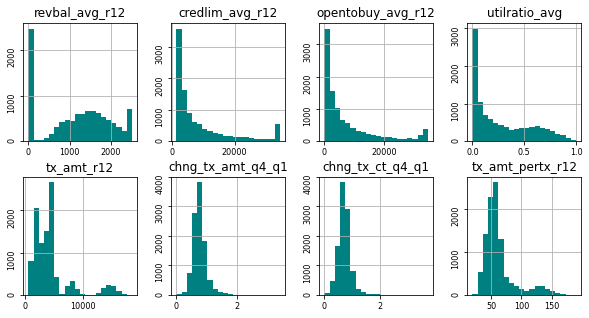

In [8]:
# histograms for continuous variables
r, c = 2, 4
d.select_dtypes('float').hist(
    xlabelsize=8, ylabelsize=8, 
    yrot=90, 
    layout=(r, c), figsize=(c*2.5, r*2.5),
    color='teal', bins=20)
plt.show()

<a id='5.1.2'>
    <h2 style='font-size:180%;'>
        Discrete Variables
    </h2>
</a>

For the discrete variables, `age` and `dependents` seem to be sufficiently-normal.

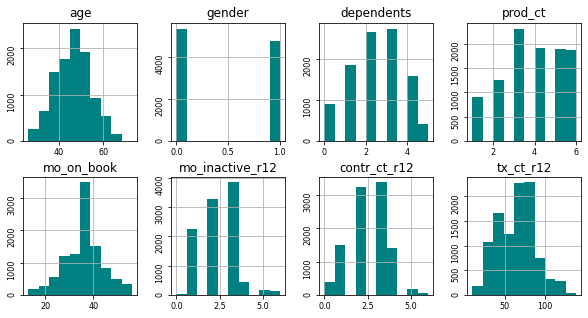

In [9]:
# histograms for discrete variables
d.select_dtypes('integer').iloc[:,1:9].hist(
    xlabelsize=8, ylabelsize=8, 
    yrot=90, 
    layout=(r, c), figsize=(c*2.5, r*2.5),
    color='teal', bins=10)
plt.show()

<a id='5.2'>
    <h2 style='font-size:210%;'>
        Skewness & Kurtosis
    </h2>
</a>

Skewness measures the skew or asymmetry of the distribution (right or left) while kurtosis measures the thickness of the distribution's tails compared to a Gaussian distribution. These are quick and simple statistical tests for normality. A perfectly normal distribution has a skew of $0$ and kurtosis of $3$ (or the fisher or excess kurtosis of $0$). A reasonably normal range for both skew and excess kurtosis is $[-1, 1]$.

<a id='5.2.1'>
    <h2 style='font-size:180%;'>
        Normal-Enough by Skewness
    </h2>
</a>

In [10]:
# `pandas.df.skew`
print('Variables with Skewness < |1|')
d_skew = d.skew(axis=0, skipna=True)
normal_skew = d_skew[d_skew.between(-1,1)]
pd.DataFrame(normal_skew).rename({0:'skew'},axis=1)

Variables with Skewness < |1|


,skew
age,-0.03
gender,0.12
dependents,-0.02
prod_ct,-0.16
mo_on_book,-0.11
mo_inactive_r12,0.63
contr_ct_r12,0.01
revbal_avg_r12,-0.15
utilratio_avg,0.72
tx_ct_r12,0.15


<a id='5.2.2'>
    <h2 style='font-size:180%;'>
        Normal-Enough by Kurtosis
    </h2>
</a>

In [11]:
# `pandas.df.kurt` calculates the fisher method
print('Variables with Kurtosis < |1|')
d_kurt = d.kurt(axis=0, skipna=True)
normal_kurt=d_kurt[d_kurt.between(-1,1)]
pd.DataFrame(normal_kurt).rename({0:'kurt'},axis=1)

Variables with Kurtosis < |1|


,kurt
age,-0.29
dependents,-0.68
mo_on_book,0.40
contr_ct_r12,0.00
utilratio_avg,-0.79
tx_ct_r12,-0.37
inc,-0.91


<a id='5.2.2'>
    <h2 style='font-size:180%;'>
        Normal-Enough by Skewness & Kurtosis
    </h2>
</a>

Both `age` and `dependents` are slightly platykurtic meaning that they have thinner tails with values more spread out compared to a normal distribution. The following features are *sufficiently normal* both in terms of skewness and kurtosis:

In [12]:
normal_stat = pd.concat([normal_skew, normal_kurt], axis=1).dropna().rename({0:'skew', 1:'kurt'}, axis=1)
normal_stat

,skew,kurt
age,-0.03,-0.29
dependents,-0.02,-0.68
mo_on_book,-0.11,0.40
contr_ct_r12,0.01,0.00
utilratio_avg,0.72,-0.79
tx_ct_r12,0.15,-0.37
inc,0.47,-0.91


<a id='5.3'>
    <h2 style='font-size:210%;'>
        QQ Plots
    </h2>
</a>

The Quantile-Quantile Plot known as the "QQ Plot" provides a visual representation of normality by comparing theoretical quantiles and the actual quantiles of the variables. The distance between the scatter plot and the red diagonal line represents deviation from a normal distribution. The QQ plot does a much better job in visualizing normality compared to a histogram or a box plot.

All features but `dependents`, `utilization ratio`, and `income` show pretty good signs of normality although the flattening of the two extremes of each of the distributions indicate high kurtosis with some possible signs of outliers. `dependents` seem to be on spot in terms of skewness but shows a wider range of flattening, consistent with the high skewness we saw above.

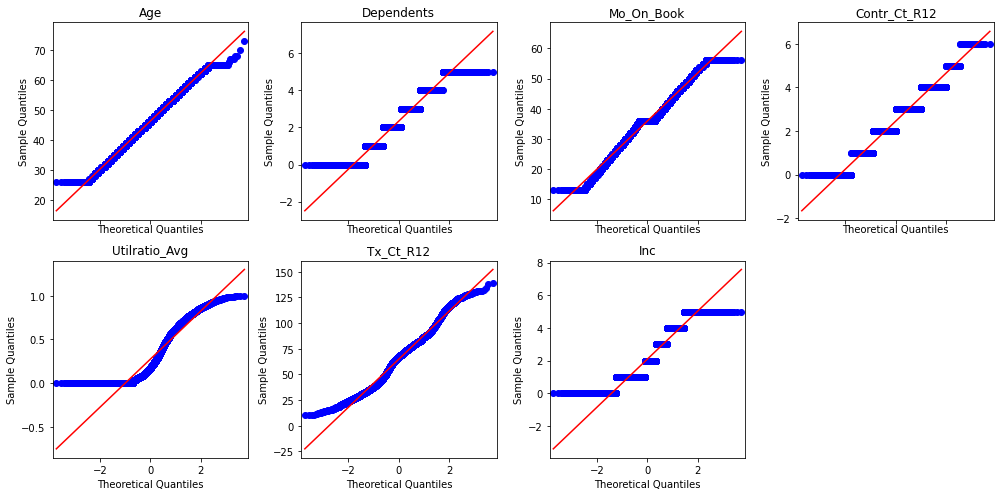

In [13]:
fig, axes = plt.subplots(ncols=4, nrows=2, sharex=True, figsize=(4*3.5, 2*3.5))
axes[1,3].set_visible(False)
for var, ax in zip(normal_stat.index, np.ravel(axes)):
    sm.qqplot(d[var], line='s', ax=ax)
    ax.set_title(f'{var.title()}')
plt.tight_layout()

<a id='5.4'>
    <h2 style='font-size:210%;'>
        Statistical Tests
    </h2>
</a>

In this section, I will try three different statistical normality tests (`Jarque-Bera`, `D'Agostino's K Square`, and `Anderson Test`) to examine if the results align with the normality patterns we observed in the previous sections. These tests can be used to confirm if the the more promising candidates are sufficiently normal for us to proceed with parametric methods.

By the Central Limit Theorem, as $n$ gets large the distribution of sample means will approximate a normal distribution. Thus, formal statistical tests to check the normality of distributions are not as useful with the full data. For this reason and for demonstration purposes, I take a sample of randomly selected $800$ examples. This way, the tests will yield results that serve the practical purposes of our analysis.

In [14]:
sample_n = 800

In [15]:
def normality_test_stat(normality_test, alpha=0.05):
    for i in normal_stat.index:
        sample = d[i].sample(sample_n, random_state=1)
        stat, p = normality_test(sample)
        print(f'`{normality_test.__qualname__}` Test Results for: `{i}`:')
        print(f'\tStatistics={stat:.3f}, p={p:.3f}')
        if p > alpha:
            print('\tSample looks Gaussian (fail to reject H0)\n')
        else:
            print('\tSample does not look Gaussian (reject H0)\n')

First, let's take a look at Jarque-Bera test which calculates kurtosis and skewness of the data to determine if the distribution deviates from the normal distribution. This test is usually better for larger datasets compared to the Shapiro-Wilk test.

[Check out the math behind this test](https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test)

<a id='5.4.3'>
    <h2 style='font-size:180%;'>
        Jarque–Bera Test
    </h2>
</a>

In [16]:
normality_test_stat(jarque_bera)

`jarque_bera` Test Results for: `age`:
	Statistics=3.493, p=0.174
	Sample looks Gaussian (fail to reject H0)

`jarque_bera` Test Results for: `dependents`:
	Statistics=13.932, p=0.001
	Sample does not look Gaussian (reject H0)

`jarque_bera` Test Results for: `mo_on_book`:
	Statistics=1.883, p=0.390
	Sample looks Gaussian (fail to reject H0)

`jarque_bera` Test Results for: `contr_ct_r12`:
	Statistics=5.692, p=0.058
	Sample looks Gaussian (fail to reject H0)

`jarque_bera` Test Results for: `utilratio_avg`:
	Statistics=90.335, p=0.000
	Sample does not look Gaussian (reject H0)

`jarque_bera` Test Results for: `tx_ct_r12`:
	Statistics=4.252, p=0.119
	Sample looks Gaussian (fail to reject H0)

`jarque_bera` Test Results for: `inc`:
	Statistics=54.699, p=0.000
	Sample does not look Gaussian (reject H0)



Next, let's take a look at D'Agostino's K Square test which is based on the squared sum of the transformations of both kurtosis and skewness of the data. The transformations allow for a faster convergence by making the distributions more normal.

[Check out the math behind this test](https://en.wikipedia.org/wiki/D%27Agostino%27s_K-squared_test)

<a id='5.4.1'>
    <h2 style='font-size:180%;'>
        D'Agostino's K Square
    </h2>
</a>

In [17]:
normality_test_stat(normaltest)

`normaltest` Test Results for: `age`:
	Statistics=3.808, p=0.149
	Sample looks Gaussian (fail to reject H0)

`normaltest` Test Results for: `dependents`:
	Statistics=28.351, p=0.000
	Sample does not look Gaussian (reject H0)

`normaltest` Test Results for: `mo_on_book`:
	Statistics=1.948, p=0.378
	Sample looks Gaussian (fail to reject H0)

`normaltest` Test Results for: `contr_ct_r12`:
	Statistics=5.803, p=0.055
	Sample looks Gaussian (fail to reject H0)

`normaltest` Test Results for: `utilratio_avg`:
	Statistics=133.172, p=0.000
	Sample does not look Gaussian (reject H0)

`normaltest` Test Results for: `tx_ct_r12`:
	Statistics=4.431, p=0.109
	Sample looks Gaussian (fail to reject H0)

`normaltest` Test Results for: `inc`:
	Statistics=142.984, p=0.000
	Sample does not look Gaussian (reject H0)



<a id='5.4.2'>
    <h2 style='font-size:180%;'>
        Anderson-Darling Test
    </h2>
</a>

The Anderson-Darling Test puts more weight on the examples in the tails of the distribution or kurtosis. Since our data contain a fair amount of outliers also characterized by higher kurtosis, we can expect to see more pessimistic results compared to the previous two tests. 

In [18]:
# from scipy.stats import normaltest
def normality_test_stat_anderson():
    for i in normal_stat.index:
        # from scipy.stats import anderson
        result = anderson(d[i].sample(sample_n, random_state=1))
        print(f'`{anderson.__qualname__}` Test Results for: `{i}`:')
        print(f'\tStatistics={result.statistic:.3}')

        for i in range(len(result.critical_values)):
            sl, cv = result.significance_level[i], result.critical_values[i]
            if result.statistic < result.critical_values[i]:
                print(f'\tp={sl/100:.3f}, critical={cv:.3f}: Sample looks Gaussian (fail to reject H0)')
            else:
                print(f'\tp={sl/100:.3f}, critical={cv:.3f}: Sample does not look Gaussian (reject H0)')

In [19]:
normality_test_stat_anderson()

`anderson` Test Results for: `age`:
	Statistics=0.929
	p=0.150, critical=0.573: Sample does not look Gaussian (reject H0)
	p=0.100, critical=0.653: Sample does not look Gaussian (reject H0)
	p=0.050, critical=0.783: Sample does not look Gaussian (reject H0)
	p=0.025, critical=0.913: Sample does not look Gaussian (reject H0)
	p=0.010, critical=1.087: Sample looks Gaussian (fail to reject H0)
`anderson` Test Results for: `dependents`:
	Statistics=21.1
	p=0.150, critical=0.573: Sample does not look Gaussian (reject H0)
	p=0.100, critical=0.653: Sample does not look Gaussian (reject H0)
	p=0.050, critical=0.783: Sample does not look Gaussian (reject H0)
	p=0.025, critical=0.913: Sample does not look Gaussian (reject H0)
	p=0.010, critical=1.087: Sample does not look Gaussian (reject H0)
`anderson` Test Results for: `mo_on_book`:
	Statistics=6.57
	p=0.150, critical=0.573: Sample does not look Gaussian (reject H0)
	p=0.100, critical=0.653: Sample does not look Gaussian (reject H0)
	p=0.050, 

`Jarque Bera` and `D'Agostino's K Square` test results indicate that under certain thresholds of $n$ and test statistic `age`, `mo_on_book`, `contr_ct_r12`, and `tx_ct_r12` are normal but `dependents`, `utilratio_avg`, and `inc` are not. `Anderson` is the most stringent as none of the variables look Gaussian under its assumptions. It is important to note that the p-values are low enough to cross the line of non-normality for `contr_ct_r12` and `tx_ct_r12`. From these tests, one can conclude that `age`, `mo_on_book`, `contr_ct_r12`, and `tx_ct_r12` may be normal enough. 

Based on these results, it might be beneficial to standardize `age`, `mo_on_book`, `contr_ct_r12`, and `tx_ct_r12` but normalize all other variables in the feature transformation section before feature selection. Before we normalize, however, we should treat the outliers as most normalization methods are sensitive to outliers.

<a id='6'>
    <h2 style='background-color:rgb(141, 153, 165);
               font-size:240%;
               color:white;
               text-align:center;
               margin: auto;
               padding: 10px;'>
        Baseline Models
    </h2>
</a>

To identify and treat outliers, we start with two baseline models:

1. Logistic Regression
2. XGBoost Classifier

The assumption is that Logistic Regression will benefit from the removal of outliers much more than does XGBoost Classifier as the former makes a strong assumption of the data's functional form, and the decision boundary is sensitive to minimum and maximum values in the data.

<a id='6.1'>
    <h2 style='font-size:210%;'>
        Functions
    </h2>
</a>

In [20]:
def result_rskf(x, y, pipeline, mod_disp_name):
    scoring = {
        'accuracy':'accuracy', 'precision':'precision', 'recall':'recall', 'f1':'f1', 
        'f2':make_scorer(fbeta_score, beta=2)} # dict val = scorer fct or predefined metric str  
    cv = RepeatedStratifiedKFold(
        n_splits=10, n_repeats=5, random_state=1)       
    result = cross_validate(
        pipeline, x, y, cv=cv, 
        scoring=scoring, return_train_score=True, n_jobs=-1)
        
    # make a summary table
    df = pd.DataFrame(
        (k, mean(v), std(v)) for k,v in result.items()
        ).rename({0:'metric', 1:'mean', 2:'std'}, axis=1
                ).set_index('metric')
    df.index.name = None
    df.columns = pd.MultiIndex.from_product([[mod_disp_name],df.columns])
    
    return df, result

In [21]:
def result_tts(x, y, pipeline, mod_disp_name):
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=1, shuffle=True, stratify=y)
    time_0 = time()
    pipeline.fit(x_train, y_train)
    time_1 = time()
    y_pred = pipeline.predict(x_test)
    time_2 = time()
    result = {}
    result['fit_time'] = round(time_1-time_0, 2)
    result['score_time'] = round(time_2-time_1, 2)
    result['accuracy'] = round(accuracy_score(y_test, y_pred), 2)
    result['precision'] = round(precision_score(y_test, y_pred), 2)
    result['recall'] = round(recall_score(y_test, y_pred), 2)
    result['f1'] = round(f1_score(y_test, y_pred), 2)
    result['f2'] = round(fbeta_score(y_test, y_pred, beta=2), 2)
    conf_mat = confusion_matrix(y_test, y_pred, labels=[1,0])
    df = pd.DataFrame(result, index=[mod_disp_name]).T
    return df, result, conf_mat, y_pred, y_test

<a id='6.1'>
    <h2 style='font-size:210%;'>
        Data Processing
    </h2>
</a>

In [22]:
# split train and test
d = d.values
x, y = d[:,1:], d[:,:1].ravel()

<a id='6.2'>
    <h2 style='font-size:210%;'>
        Logistic Regression
    </h2>
</a>

First, we fit the logistic regression model. Although this model is more sensitive to multicollinearity, we will ignore this factor as this section's goal is to demonstrate the effect of removing outliers only. Multicolinearity will be taken care of in the feature selection section. Other factors that affect the model's performance such as model selection and hyperparameter tuning etc. will also be discussed in the later sections.

<a id='6.2.1'>
    <h2 style='font-size:180%;'>
        Model Attributes
    </h2>
</a>

In [23]:
print("Logistic Regression Parameters:")
LR_params = LogisticRegression().get_params()
LR_params

Logistic Regression Parameters:


{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [24]:
print(f"""Logistic Regression Default Parameter Values:""")
LR_params_key = ['C','solver','max_iter']
LR_params_key = {k:v for k,v in LR_params.items() if k in LR_params_key}
print(LR_params_key)

Logistic Regression Default Parameter Values:
{'C': 1.0, 'max_iter': 100, 'solver': 'lbfgs'}


<a id='6.2.2'>
    <h2 style='font-size:180%;'>
        Model Fit & Evaluation
    </h2>
</a>

Notes on L1 and L2 regularization:
> *Introducing a penalty to the sum of the weights means that the model has to "distribute" its weights optimally, so naturally most of this "resource" will go to the simple features that explain most of the variance, with complex features getting small or zero weights.*

[Edden Gerber, *Comment on a Medium Article*](https://medium.com/@edden.gerber/thanks-for-the-article-1003ad7478b2)

<a id='6.2.2.1'>
    <h2 style='font-size:150%;'>
        Define Model & Pipeline
    </h2>
</a>

In [25]:
model = LogisticRegression(class_weight='balanced', C=0.1, max_iter=10000, random_state=1)
pipeline = Pipeline([('m', model)])

<a id='6.2.2.2'>
    <h2 style='font-size:150%;'>
        Repeated Stratified K-Fold Cross Validation
    </h2>
</a>

In [26]:
LR_baseline_rskf_inst = result_rskf(x, y, pipeline, 'LR')

In [27]:
LR_baseline_rskf_summary = LR_baseline_rskf_inst[0]
LR_baseline_rskf_full = LR_baseline_rskf_inst[1]

In [28]:
LR_baseline_rskf_summary

LR     
                mean  std
fit_time        4.04 3.41
score_time      0.02 0.02
test_accuracy   0.84 0.01
train_accuracy  0.85 0.01
test_precision  0.51 0.02
train_precision 0.51 0.02
test_recall     0.85 0.03
train_recall    0.85 0.00
test_f1         0.64 0.02
train_f1        0.64 0.01
test_f2         0.75 0.02
train_f2        0.75 0.01

<a id='6.2.2.3'>
    <h2 style='font-size:150%;'>
        Train-Test Split Cross Validation
    </h2>
</a>

In [29]:
LR_baseline_tts_inst = result_tts(x, y, pipeline, 'LR')

In [30]:
LR_baseline_tts_summary = LR_baseline_tts_inst[0]
LR_baseline_tts_full = LR_baseline_tts_inst[1]
LR_baseline_tts_cm = LR_baseline_tts_inst[2]
LR_baseline_tts_y_pred = LR_baseline_tts_inst[3]
LR_baseline_tts_y_test = LR_baseline_tts_inst[4]
tp, fn, fp, tn = LR_baseline_tts_cm.ravel()

In [31]:
LR_baseline_tts_summary

,LR
fit_time,0.62
score_time,0.00
accuracy,0.84
precision,0.50
recall,0.88
f1,0.64
f2,0.76


<a id='6.2.2.4'>
    <h2 style='font-size:150%;'>
        Performance Metrics - Manual Calculation
    </h2>
</a>

In [32]:
recall = round(tp/(tp+fn),2)
precision = round(tp/(tp+fp),2)
f1 = round(2*(recall*precision)/(recall+precision),2)

In [33]:
recall, precision, f1

(0.88, 0.5, 0.64)

<a id='6.3'>
    <h2 style='font-size:210%;'>
        Gradient Boosting Classifier
    </h2>
</a>

For our emsemble baseline model we fit the XGBoost Classifier again without any feature selection or hyperparameter tuning. No normalization is necessary with this model since it is an ensemble of the tree methods. This means that removing outliers should not cause any material impact to the model's performance since the algorithm is not sensitive to monotonic transformations of its features.

<a id='6.3.1'>
    <h2 style='font-size:180%;'>
        Model Attributes
    </h2>
</a>

In [34]:
print("Gradient Boosting Classifier Parameters:")
GB_params = GradientBoostingClassifier().get_params()
GB_params

Gradient Boosting Classifier Parameters:


{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [35]:
print(f"""Gradient Boosting Classifier Default Parameter Values:""")
GB_params_key = ['n_estimators','max_depth','learning_rate']
GB_params_key = {k:v for k,v in GB_params.items() if k in GB_params_key}
print(GB_params_key)

Gradient Boosting Classifier Default Parameter Values:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


<a id='6.3.2'>
    <h2 style='font-size:180%;'>
        Model Fit & Evaluation
    </h2>
</a>

<a id='6.3.2.1'>
    <h2 style='font-size:150%;'>
        Define Model & Pipeline
    </h2>
</a>

In [36]:
model = GradientBoostingClassifier(n_estimators=300, max_depth=3, learning_rate=0.1)
pipeline = Pipeline([('m', model)])

<a id='6.3.2.2'>
    <h2 style='font-size:150%;'>
        Repeated Stratified K-Fold Cross Validation
    </h2>
</a>

In [37]:
GB_baseline_rskf_inst = result_rskf(x, y, pipeline, 'GB')

In [38]:
GB_baseline_rskf_summary = GB_baseline_rskf_inst[0]
GB_baseline_rskf_full = GB_baseline_rskf_inst[1]

In [39]:
GB_baseline_rskf_summary

GB     
                 mean  std
fit_time        32.68 5.62
score_time       0.04 0.01
test_accuracy    0.97 0.00
train_accuracy   0.99 0.00
test_precision   0.94 0.02
train_precision  0.98 0.00
test_recall      0.89 0.02
train_recall     0.96 0.00
test_f1          0.91 0.01
train_f1         0.97 0.00
test_f2          0.90 0.02
train_f2         0.96 0.00

<a id='6.3.2.3'>
    <h2 style='font-size:150%;'>
        Train-Test Split Cross Validation
    </h2>
</a>

In [40]:
GB_baseline_tts_inst = result_tts(x, y, pipeline, 'GB')

In [41]:
GB_baseline_tts_summary = GB_baseline_tts_inst[0]
GB_baseline_tts_full = GB_baseline_tts_inst[1]
GB_baseline_tts_cm = GB_baseline_tts_inst[2]
GB_baseline_tts_y_pred = GB_baseline_tts_inst[3]
GB_baseline_tts_y_test = GB_baseline_tts_inst[4]
tp, fn, fp, tn = GB_baseline_tts_cm.ravel()

In [42]:
GB_baseline_tts_summary

,GB
fit_time,12.15
score_time,0.01
accuracy,0.98
precision,0.94
recall,0.94
f1,0.94
f2,0.94


<a id='6.3.2.4'>
    <h2 style='font-size:150%;'>
        Performance Metrics - Manual Calculation
    </h2>
</a>

In [43]:
recall = round(tp/(tp+fn),2)
precision = round(tp/(tp+fp),2)
f1 = round(2*(recall*precision)/(recall+precision),2)

In [44]:
recall, precision, f1

(0.94, 0.94, 0.94)

<a id='6.4'>
    <h2 style='font-size:210%;'>
        Model Comparison
    </h2>
</a>

<a id='6.4.1'>
    <h2 style='font-size:180%;'>
        Logistic Regression vs. Gradient Boosting Classifier
    </h2>
</a>

In [45]:
baseline_rskf_summary = pd.concat([LR_baseline_rskf_summary, GB_baseline_rskf_summary], axis=1)

In [46]:
baseline_rskf_summary

LR         GB     
                mean  std  mean  std
fit_time        4.04 3.41 32.68 5.62
score_time      0.02 0.02  0.04 0.01
test_accuracy   0.84 0.01  0.97 0.00
train_accuracy  0.85 0.01  0.99 0.00
test_precision  0.51 0.02  0.94 0.02
train_precision 0.51 0.02  0.98 0.00
test_recall     0.85 0.03  0.89 0.02
train_recall    0.85 0.00  0.96 0.00
test_f1         0.64 0.02  0.91 0.01
train_f1        0.64 0.01  0.97 0.00
test_f2         0.75 0.02  0.90 0.02
train_f2        0.75 0.01  0.96 0.00

In [47]:
baseline_tts_summary = pd.concat([LR_baseline_tts_summary, GB_baseline_tts_summary], axis=1)

In [48]:
baseline_tts_summary

,LR,GB
fit_time,0.62,12.15
score_time,0.00,0.01
accuracy,0.84,0.98
precision,0.50,0.94
recall,0.88,0.94
f1,0.64,0.94
f2,0.76,0.94


<a id='7'>
    <h2 style='background-color:rgb(141, 153, 165);
               font-size:240%;
               color:white;
               text-align:center;
               margin: auto;
               padding: 10px;'>
        Outlier Treatment
    </h2>
</a>

In the Data Visualization section, we saw a large number of outliers in the box plots. Let's explore the effects of removing the outliers using Isolation Forest.

<a id='7.1'>
    <h2 style='font-size:210%;'>
        Isolation Forest
    </h2>
</a>

Isolation Forest is a tree-based one-class classification method that isolates observations that are few in number and different in their attributes or feature space without the usage of any distance or density measure like One-Class SVM.

Tree structures are designed to separate out anomalies. The algorithm has shallow roots for the isolated examples and deeper roots for the normal examples. The two important hyperparameters in the model are `n_estimators` and `contamination`. `n_estimators` sets the number of trees and `contamination` sets the percentage of outliers to detect.

**Isolation Forest pros:**
* There is no need of scaling the values in the feature space.
* It is an effective method when value distributions can not be assumed.
* It has few parameters, this makes this method fairly robust and easy to optimize.
* Scikit-Learn’s implementation is easy to use and the documentation is superb.

**Isolation Forest cons:**
* The Python implementation exists only in the development version of Sklearn.
* Visualizing results is complicated.
* If not correctly optimized, training time can be very long and computationally expensive.

[Source: Towards Data Science - A Brief Overview of Outlier Detection Techniques](https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561)

<a id='7.2'>
    <h2 style='font-size:210%;'>
        Fit on All Classes
    </h2>
</a>

In [49]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle=True, stratify=y)

The goal here is to test on all training dataset without the outliers.

<h2 style='font-size:180%;'>
    Model Attributes
</h2>

In [50]:
print("Isolation Forest Parameters:")
IF_params = IsolationForest().get_params()
IF_params

Isolation Forest Parameters:


{'bootstrap': False,
 'contamination': 'auto',
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [51]:
print(f"""Isolation Forest Default Parameter Values:""")
IF_params_key = ['contamination','n_estimators','max_features']
IF_params_key = {k:v for k,v in IF_params.items() if k in IF_params_key}
print(IF_params_key)

Isolation Forest Default Parameter Values:
{'contamination': 'auto', 'max_features': 1.0, 'n_estimators': 100}


In [52]:
count = Counter(y)
print('`y` split:')
count

`y` split:


Counter({0.0: 8500, 1.0: 1627})

In [53]:
count = Counter(y_train)
print('`y_train` split - pre-treatment:')
count

`y_train` split - pre-treatment:


Counter({0.0: 6799, 1.0: 1302})

<!-- I chose 5% for the sample size of outliers. In other words, we will keep 95% of the data. -->

In [71]:
def result_tts_with_data(x_train, x_test, y_train, y_test, pipeline, mod_disp_name):
    time_0 = time()
    pipeline.fit(x_train, y_train)
    time_1 = time()
    y_pred = pipeline.predict(x_test)
    time_2 = time()
    result = {}
    result['fit_time'] = round(time_1-time_0, 2)
    result['score_time'] = round(time_2-time_1, 2)
    result['accuracy'] = round(accuracy_score(y_test, y_pred), 2)
    result['precision'] = round(precision_score(y_test, y_pred), 2)
    result['recall'] = round(recall_score(y_test, y_pred), 2)
    result['f1'] = round(f1_score(y_test, y_pred), 2)
    result['f2'] = round(fbeta_score(y_test, y_pred, beta=2), 2)
    conf_mat = confusion_matrix(y_test, y_pred, labels=[1,0])
    df = pd.DataFrame(result, index=[mod_disp_name]).T
    return df, result, conf_mat, y_pred, y_test

In [55]:
model_outlier = IsolationForest(contamination='auto')
y_pred = model_outlier.fit_predict(x_train)

In [56]:
# removing outliers from the training set
x_train, y_train = x_train[y_pred!=-1,:], y_train[y_pred!=-1]

In [57]:
count = Counter(y_train)
print('`y_train` split - post-treatment:')
count

`y_train` split - post-treatment:


Counter({0.0: 5803, 1.0: 1081})

In [58]:
print('Percentage of churned customer in the new data: %.2f%%' % (count[1]/len(y_train)*100))

Percentage of churned customer in the new data: 15.70%


In [59]:
print('Shape of the new train set for `x_train` and `y_train`, respectively:')
print(x_train.shape, y_train.shape)

Shape of the new train set for `x_train` and `y_train`, respectively:
(6884, 26) (6884,)


In [60]:
print('Sample size of total data: %.2f%%' % (len(x_train)/8101*100))

Sample size of total data: 84.98%


<a id='7.2.1'>
    <h2 style='font-size:180%;'>
        Logistic Regression
    </h2>
</a>

In [61]:
model = LogisticRegression(class_weight='balanced', C=0.1, max_iter=10000, random_state=1)
pipeline = Pipeline([('m', model)])

In [62]:
LR_outlier_tts_inst = result_tts_with_data(x_train, x_test, y_train, y_test, pipeline, 'LR')

In [63]:
LR_outlier_tts_summary = LR_outlier_tts_inst[0]
LR_outlier_tts_full = LR_outlier_tts_inst[1]
LR_outlier_tts_cm = LR_outlier_tts_inst[2]
LR_outlier_tts_y_pred = LR_outlier_tts_inst[3]
LR_outlier_tts_y_test = LR_outlier_tts_inst[4]

In [64]:
LR_baseline_vs_outlier_tts = pd.concat([LR_outlier_tts_summary, LR_baseline_tts_summary], axis=1)
LR_baseline_vs_outlier_tts.columns=pd.MultiIndex.from_product([['LR'],['Trmt','Ctrl']])

In [65]:
LR_baseline_vs_outlier_tts

LR     
           Trmt Ctrl
fit_time   0.65 0.62
score_time 0.00 0.00
accuracy   0.84 0.84
precision  0.50 0.50
recall     0.87 0.88
f1         0.64 0.64
f2         0.76 0.76

<a id='7.2.2'>
    <h2 style='font-size:180%;'>
        Gradient Boosting Classifier
    </h2>
</a>

In [66]:
model = GradientBoostingClassifier(n_estimators=300, max_depth=3, learning_rate=0.1)
pipeline = Pipeline([('m', model)])

In [67]:
GB_outlier_tts_inst = result_tts_with_data(x_train, x_test, y_train, y_test, pipeline, 'GB')

In [68]:
GB_outlier_tts_summary = GB_outlier_tts_inst[0]
GB_outlier_tts_full = GB_outlier_tts_inst[1]
GB_outlier_tts_cm = GB_outlier_tts_inst[2]
GB_outlier_tts_y_pred = GB_outlier_tts_inst[3]
GB_outlier_tts_y_test = GB_outlier_tts_inst[4]

In [69]:
GB_baseline_vs_outlier_tts = pd.concat([GB_outlier_tts_summary, GB_baseline_tts_summary], axis=1)
GB_baseline_vs_outlier_tts.columns=pd.MultiIndex.from_product([['GB'],['Trmt','Ctrl']])

In [70]:
GB_baseline_vs_outlier_tts

GB      
           Trmt  Ctrl
fit_time   8.16 12.15
score_time 0.01  0.01
accuracy   0.98  0.98
precision  0.95  0.94
recall     0.93  0.94
f1         0.94  0.94
f2         0.93  0.94

<a id='7.3'>
    <h2 style='font-size:210%;'>
        Evaluate Results
    </h2>
</a>

As expected, the linear model (logistic regression) saw a slight improvement in F-2 score (more gain in precision) while the ensemble model (Gradient Boosting Classifier) saw a large hit due to information loss. We may want to revisit removing outliers after scaling, feature selection/extraction, and/or resampling.

In [72]:
baseline_vs_outlier_tts = pd.concat([LR_baseline_vs_outlier_tts, GB_baseline_vs_outlier_tts], axis=1)
baseline_vs_outlier_tts

LR        GB      
           Trmt Ctrl Trmt  Ctrl
fit_time   0.65 0.62 8.16 12.15
score_time 0.00 0.00 0.01  0.01
accuracy   0.84 0.84 0.98  0.98
precision  0.50 0.50 0.95  0.94
recall     0.87 0.88 0.93  0.94
f1         0.64 0.64 0.94  0.94
f2         0.76 0.76 0.93  0.94